In [1]:
# import ee
from IPython import display
# import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
import rasterio
from zipfile import *
import math
from math import sqrt
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
import time

In [2]:
import os

path = 'C:/Users/ipdavies/CPR/data/'

# Get list of all images
img_list = []
for file in os.listdir(path):
        img_list.append(file)

print(img_list)

img = '4337_LC08_026038_20160325_1'

['.ipynb_checkpoints', 'cloudmasks', 'images', 'models', 'tables']


Assuming tifs are already stacked into a "stack.tif" image

In [5]:
# Get local image
with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Convert -999999 to None
data[data == -999999] = np.nan

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]

feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

df = pd.DataFrame(data = np.round(data_vector, 2), columns = feat_list_new)

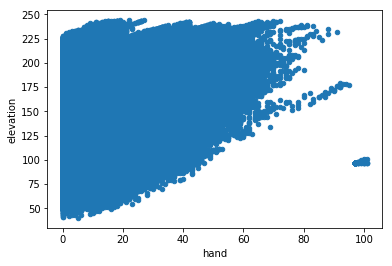

In [5]:
df.plot.scatter(x='hand',y='elevation')

In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,aspect,curve,developed,distExtent,elevation,forest,GSW_maxExtent,hand,other_landcover,planted,slope,spi,twi,wetlands,flooded
aspect,1,-0.00173454,0.00836664,0.0299389,0.0458954,0.0334696,-0.189551,0.134761,0.0186291,0.0266437,0.213818,0.0116116,-0.35688,0.015737,-0.204909
curve,-0.00173454,1,-0.00514739,-0.00112637,-0.0788641,-0.0402111,0.0291752,-0.227525,0.0138374,0.0379559,-0.00988442,0.000832263,0.0081038,-0.0301834,0.025573
developed,0.00836664,-0.00514739,1,0.0130748,0.0832626,-0.165507,-0.0562168,1.89613e-05,-0.131357,-0.205644,-0.0156202,-0.0129467,-0.0411612,-0.10238,-0.0541534
distExtent,0.0299389,-0.00112637,0.0130748,1,0.127723,0.0930583,-0.163748,0.058322,0.00972837,-0.0299928,0.0480097,-0.0413086,-0.0978139,-0.0139877,-0.144818
elevation,0.0458954,-0.0788641,0.0832626,0.127723,1,0.0778619,-0.233702,0.308296,0.0385694,0.00142048,0.130465,-0.119537,-0.202437,-0.127119,-0.1758
forest,0.0334696,-0.0402111,-0.165507,0.0930583,0.0778619,1,-0.111226,0.1696,-0.266543,-0.417283,0.107865,-0.0148746,-0.0871672,-0.207746,-0.113521
GSW_maxExtent,-0.189551,0.0291752,-0.0562168,-0.163748,-0.233702,-0.111226,1,-0.193595,-0.0483957,-0.129646,-0.190872,0.0648749,0.494038,-0.0504039,0.830303
hand,0.134761,-0.227525,1.89613e-05,0.058322,0.308296,0.1696,-0.193595,1,0.00195982,-0.108945,0.318571,-0.00759498,-0.217092,0.0420353,-0.183002
other_landcover,0.0186291,0.0138374,-0.131357,0.00972837,0.0385694,-0.266543,-0.0483957,0.00195982,1,-0.331182,-0.00577337,-0.0105296,-0.0526773,-0.16488,-0.0698129
planted,0.0266437,0.0379559,-0.205644,-0.0299928,0.00142048,-0.417283,-0.129646,-0.108945,-0.331182,1,-0.021982,-0.0254836,-0.0931035,-0.258126,-0.13462


In [7]:
corr.to_csv('C:/Users/ipdavies/CPR/data/tables/EDA/4337_LC08_026038_20160325_1.csv')